Import relevant libraries

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

Define a class for AddGaussianNoise

In [116]:
# Define a class AddGaussianNoise
class AddGaussianNoise(object):
    # Initialize the AddGaussianNoise object with mean and standard deviation values
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    # Add Gaussian noise to the input tensor
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    # Return a string representation of the AddGaussianNoise object
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Define a transform to convert images to tensors and add gaussian noise

In [117]:
# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

trans = transforms.ToTensor()

Load Training Data

In [118]:
# Load the MNIST dataset with gaussian noise
mnist_data_gauss = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

mnist_test_gauss =  datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a data loader to load the data with gaussian noise in batches
data_loader_gauss = torch.utils.data.DataLoader(dataset=mnist_data_gauss, batch_size=64, shuffle=False)
# Create a data loader to load the data in batches
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=False)

test_data_loader_gauss = torch.utils.data.DataLoader(dataset=mnist_test_gauss, batch_size=10000, shuffle=False)

dataiter = iter(data_loader_gauss)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(-4.6824) tensor(5.8920)


Definition of the Autoencoder with a Bottleneck layer of 49 neurons

In [119]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # N, 784
        self.encoder = nn.Sequential(
            nn.Linear(784, 500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 200)
        )

        self.decoder = nn.Sequential(
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Linear(300, 500),
            nn.ReLU(),
            nn.Linear(500, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Train the Autoencoder for n epochs

In [120]:
# These lines define the loss function (MSE loss), instantiate the Autoencoder model
# learning rate of 1e-3 and L2 regularization with a weight decay of 1e-5.
criterion = nn.MSELoss()
model = Autoencoder()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-10, momentum=0.9)

# train the model over n epochs
num_epochs = 100
outputs = []

for epoch in range(num_epochs):
    for j in range(0,500):
        rand_index = random.randint(0, 49999)
        img, _ = mnist_data_gauss[rand_index]
        img = img.reshape(-1, 28 * 28)
        recon = model(img)

        real_img, _ = mnist_data[rand_index]
        real_img = real_img.reshape(-1, 28 * 28)
        loss = criterion(recon, real_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0977
Epoch:2, Loss:0.0806
Epoch:3, Loss:0.0607
Epoch:4, Loss:0.0769
Epoch:5, Loss:0.0532
Epoch:6, Loss:0.0625
Epoch:7, Loss:0.0536
Epoch:8, Loss:0.0502
Epoch:9, Loss:0.0576
Epoch:10, Loss:0.0164
Epoch:11, Loss:0.0108
Epoch:12, Loss:0.0238
Epoch:13, Loss:0.0167
Epoch:14, Loss:0.0331
Epoch:15, Loss:0.0622
Epoch:16, Loss:0.0198
Epoch:17, Loss:0.0123
Epoch:18, Loss:0.0279
Epoch:19, Loss:0.0292
Epoch:20, Loss:0.0435
Epoch:21, Loss:0.0262
Epoch:22, Loss:0.0299
Epoch:23, Loss:0.0159
Epoch:24, Loss:0.0331
Epoch:25, Loss:0.0421
Epoch:26, Loss:0.0243
Epoch:27, Loss:0.0296
Epoch:28, Loss:0.0446
Epoch:29, Loss:0.0318
Epoch:30, Loss:0.0248
Epoch:31, Loss:0.0139
Epoch:32, Loss:0.0330
Epoch:33, Loss:0.0356
Epoch:34, Loss:0.0331
Epoch:35, Loss:0.0123
Epoch:36, Loss:0.0271
Epoch:37, Loss:0.0281
Epoch:38, Loss:0.0198
Epoch:39, Loss:0.0090
Epoch:40, Loss:0.0141
Epoch:41, Loss:0.0351
Epoch:42, Loss:0.0317
Epoch:43, Loss:0.0485
Epoch:44, Loss:0.0079
Epoch:45, Loss:0.0215
Epoch:46, Loss:0.02

Plot the reconstructed images versus the images with Gaussian noise for every 20. epoch

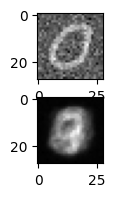

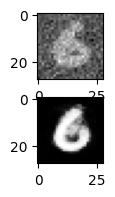

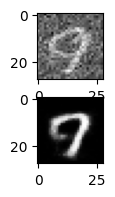

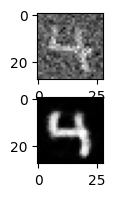

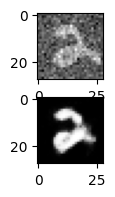

In [121]:
# Plot the resulting images
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9 + i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

plt.show()

Run Random Forest Classifier on encoded data

In [123]:
encPics = []
labels = []

for (img, l) in test_data_loader_gauss:
    item = img.reshape(-1, 28 * 28)
    enc = model.encoder(item)
    enc = enc.detach().numpy()
    l = l.detach().numpy()
    encPics.append(enc)
    labels.append(l)

rf = RandomForestClassifier(n_estimators=266, max_depth=11)
encPics = np.reshape(encPics, (-1, 200))
labels = np.reshape(labels, (-1, 1))
labels = labels.ravel()
rf.fit(encPics, labels)
y_pred_1 = rf.predict(encPics)

accscore = accuracy_score(labels, y_pred_1, normalize=True)
print(accscore)

print(classification_report(labels, y_pred_1))

0.9937
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      1.00       982
           5       1.00      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

